### 事前準備

In [1]:
!pip install -q captum

     |████████████████████████████████| 1.4 MB 5.4 MB/s 


In [2]:
import numpy as np

import requests
from io import BytesIO

from PIL import Image

import torchvision
from torchvision import transforms

from captum.attr import Occlusion
from captum.attr import visualization as viz

In [3]:
# モデルの読み込み
model = torchvision.models.resnet50(pretrained=True).eval()

# 画像の読み込み
response = requests.get("https://image.freepik.com/free-photo/two-beautiful-puppies-cat-dog_58409-6024.jpg")
img = Image.open(BytesIO(response.content))

# transforms
transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_img = transform(img).unsqueeze(0)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

### Occulusion
https://captum.ai/api/occlusion.html

In [4]:
occlusion = Occlusion(model)

strides = (3, 9, 9)                                         # より小さい＝よりきめ細かいアトリビューションが可能だが、速度が遅い
target=208                                                  # ImageNetにおけるラブラドール（Labrador retriever）のインデックス  
sliding_window_shapes=(3, 45, 45)
baselines = 0

attribution_dog = occlusion.attribute(input_img,
                                      strides = strides,
                                      target=target,
                                      sliding_window_shapes=sliding_window_shapes,
                                      baselines=baselines)


target=283                                                  # ImageNetにおけるペルシアン猫（Persian cat）のインデックス
attribution_cat = occlusion.attribute(input_img,
                                      strides = strides,
                                      target=target,
                                      sliding_window_shapes=sliding_window_shapes,
                                      baselines=0)

### 可視化

In [5]:
center_crop = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
])

# compute attributionのテンソルをimageのようなnumpy配列に変換する
# 配列の軸の順番を入れ替える
attribution_dog = np.transpose(attribution_dog.squeeze().cpu().detach().numpy(), (1,2,0))
attribution_cat = np.transpose(attribution_cat.squeeze().cpu().detach().numpy(), (1,2,0))

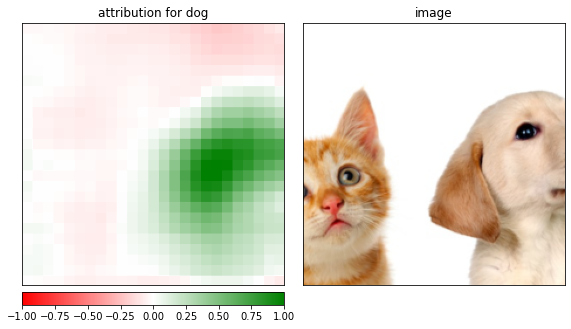

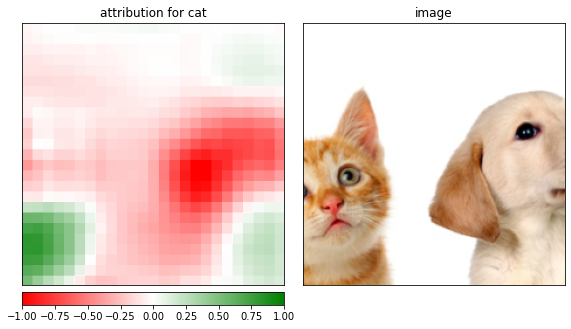

In [6]:
vis_types = ["heat_map", "original_image"]
vis_signs = ["all", "all"]

_ = viz.visualize_image_attr_multiple(attribution_dog,
                                      np.array(center_crop(img)),
                                      vis_types,
                                      vis_signs,
                                      ["attribution for dog", "image"],
                                      show_colorbar = True
                                     )

_ = viz.visualize_image_attr_multiple(attribution_cat,
                                      np.array(center_crop(img)),
                                      ["heat_map", "original_image"],
                                      ["all", "all"],
                                      ["attribution for cat", "image"],
                                      show_colorbar = True
                                     )